# Semester 3 Coding Portfolio Topic 3 Formative Part 2/2:
# Evaluating Model Performance for Numerical Data

This notebook covers the following topics:
 - Construct **train/validation/test** splits reproducibly.
 - Fit **OLS** regression and build proper **design matrices** (incl. intercept).
 - Evaluate models with **bias**, **RMSE**, **correlation**, and **coverage**.
 - Generate **prediction intervals** via posterior-predictive simulations.
 - Interpret model comparisons and reason about **bias–variance** trade-offs.

This notebook is expected to take around 5 hours to complete:
 - 2 hours for the formative part
 - 3 hours of self-study on the topics covered by this notebook

Like all topics in this portfolio, this topic is split into two sections:
 - Formative 
 - Summative

<b>Formative section</b><br>
Simply complete the given functions such that they pass the automated tests. This part is graded Pass/Fail; you must get 100% correct!
You can submit your notebook through Canvas as often as you like. Make sure to start doing so early to insure that your code passes all tests!
You may ask for help from fellow students and TAs on this section, and solutions might be provided later on.

### Motivation
When we deploy linear models, we don’t just want a **single score**—we want to understand **how well** they generalize, **what kinds of errors** they make, and **how uncertain** their predictions are. This notebook shows how to (1) split data correctly, (2) train models of increasing complexity, (3) evaluate them with multiple metrics, and (4) quantify uncertainty in those metrics using posterior-predictive simulations.

### Overview
1. **Data prep & split**: Build train/validation/test sets and create design matrices.  
2. **Modeling**: Fit several linear models (intercept-only, national-only, full).  
3. **Evaluation**: Compute bias, RMSE, correlation, and empirical coverage on validation data.  
4. **Uncertainty**: Simulate from the fitted model to obtain **distributions** of metrics (not just point estimates).  
5. **Reflection**: Compare models and discuss bias–variance trade-offs and coverage.



In [1]:
# MESSAGE FOR STUDENTS AND TA'S: I am finding most of the issues students face are related to package versions. 
# I believe the versions asserted below should be sufficient to run this notebook. 
# In case of problems, I am also uploading the environment file I used to create a conda environment that works for me.

import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error
from packaging import version

assert sys.version_info >= (3, 9), "This notebook requires Python 3.9 or above."
assert version.parse(pd.__version__) >= version.parse("1.5"), "Needs Pandas >= 1.5."
assert version.parse(np.__version__) >= version.parse("1.21"), "Needs NumPy >= 1.21."
assert version.parse(sm.__version__) >= version.parse("0.12"), "Needs Statsmodels >= 0.12."
assert version.parse(matplotlib.__version__) >= version.parse("3.4"), "Needs Matplotlib >= 3.4."
assert version.parse(sklearn.__version__) >= version.parse("1.0"), "Needs scikit-learn >= 1.0."

We evaluate linear models using **validation data** to approximate generalization.  
Given design matrix $X$ and target $y$, OLS estimates coefficients $\hat{W}$.  
Under standard assumptions, $\hat{W}$ is approximately normal:

$$
\hat{W} \sim \mathcal{N}\!\bigl(W,\ \mathrm{Cov}(\hat{W})\bigr).
$$

We use this asymptotic normality plus a Gaussian noise model to generate
**posterior-predictive draws**:

1. Sample $W^{(s)} \sim \mathcal{N}\!\bigl(\hat{W},\, \widehat{\mathrm{Cov}}(\hat{W})\bigr)$.
2. Compute means $\mu^{(s)} = X_{\text{val}}\, W^{(s)}$.
3. Sample $y^{(s)} \sim \mathcal{N}\!\bigl(\mu^{(s)},\, \hat{\sigma}^2\bigr)$.

From $\{y^{(s)}\}$ we get **prediction intervals**, and by computing metrics per draw we get
**distributions of metrics**—giving a sense of **uncertainty** in the evaluation itself,
not just in predictions.


In [2]:
# Load TFC data
df = pd.read_csv('sem3_topic3_linreg_formative2_data.csv')

# Make the states into dummies - we will work with them as dummies from here on 
state_dummies = pd.get_dummies(df['state'], prefix='state', drop_first=True)
state_dummies = state_dummies.astype(float) 

# Concatenate the dummy variables with the DataFrame
df = pd.concat([df, state_dummies], axis=1)
df = df.drop('state', axis=1)

# Let's take a look at the data we loaded
print(df.head())

   year  term2  pct_2p_vote  lagged_pct_2p_vote  real_gdp_pct_growth  \
0  1980      1    47.448859           55.727269                 -0.3   
1  1980      1    26.407902           35.653131                 -0.3   
2  1980      1    28.244684           39.799978                 -0.3   
3  1980      1    47.522631           64.961728                 -0.3   
4  1980      1    35.919437           47.954822                 -0.3   

   net_approval  state_ALASKA  state_ARIZONA  state_ARKANSAS  \
0           -18           0.0            0.0             0.0   
1           -18           1.0            0.0             0.0   
2           -18           0.0            1.0             0.0   
3           -18           0.0            0.0             1.0   
4           -18           0.0            0.0             0.0   

   state_CALIFORNIA  ...  state_SOUTH DAKOTA  state_TENNESSEE  state_TEXAS  \
0               0.0  ...                 0.0              0.0          0.0   
1               0.0  ...  

### Exercise 1a: Split your dataset into three parts (training, validation and test). 

In [3]:
# Obtain the list of all ids (indices) in the dataframe
ids = df.index.tolist()  

# Shuffle the ids
np.random.seed(42)  # For reproducibility
np.random.shuffle(ids)

# Calculate split sizes
total_size = len(ids)
train_size = int(total_size * 0.5)
validation_size = int(total_size * 0.25)
# The remaining 25% will be for the test set

# Split the ids into train, validation, and test sets
train_ids = ids[:train_size]
validation_ids = ids[train_size:train_size + validation_size]
test_ids = ids[train_size + validation_size:]

# Create the actual splits
train_set = df.loc[train_ids]
validation_set = df.loc[validation_ids]
test_set = df.loc[test_ids]

#. Your solution here ...




### Exercise 1b: Create the design matrices

In [4]:
# Create the design matrices - add a constant to the training and validation (and test, whilst we are at it) design matrices

# Training set
train_X = train_set.drop(['pct_2p_vote', 'year'], axis=1)
train_y = train_set['pct_2p_vote']
# Add constant term
train_X_full = sm.add_constant(train_X)

# Validation set
valid_X = validation_set.drop(['pct_2p_vote', 'year'], axis=1)
valid_y = validation_set['pct_2p_vote']
valid_X_full = sm.add_constant(valid_X)

# Test set
test_X = test_set.drop(['pct_2p_vote', 'year'], axis=1)
test_y = test_set['pct_2p_vote']
test_X_full = sm.add_constant(test_X)


#. Your solution here ...    




### Exercise 1c: Build a function to evaluate a linear regression model 

This function fits an OLS model, then uses the asymptotic normal distribution of the OLS coefficients and a Gaussian noise model to simulate the posterior predictive.
It returns point summaries (median prediction, PI) and evaluation metrics on the validation set.


In [5]:
def fit_predict_evaluate(train_X, train_y, valid_X, valid_y, credibility_pct=95, n_sims=1000):
    
    rng = np.random.default_rng(42)  # For reproducibility
    
    # Fit the model
    model = sm.OLS(train_y, train_X).fit()

    W_hat = model.params.values
    cov_matrix = model.cov_params().values
    residual_std = np.sqrt(model.mse_resid)

    # Simulate W from the posterior distribution
    simulated_W = rng.multivariate_normal(W_hat, cov_matrix, size=n_sims)
    # Calculate simulated mu for the validation set
    simulated_mus = simulated_W @ valid_X.T
    # Simulate y based on simulated mu and residual standard error
    simulated_ys = rng.normal(simulated_mus, residual_std)

    # Calculate prediction summaries
    simulated_y_median = np.median(simulated_ys, axis=0)
    lower_percentile = (100 - credibility_pct) / 2
    upper_percentile = 100 - lower_percentile
    prediction_intervals = np.percentile(simulated_ys, [lower_percentile, upper_percentile], axis=0)

    # Calculate metrics
    bias = np.mean(simulated_y_median - valid_y)
    rmse = np.sqrt(mean_squared_error(valid_y, simulated_y_median))
    correlation = np.corrcoef(valid_y.values.flatten(), simulated_y_median)[0, 1]
    coverage = np.mean((valid_y.values.flatten() >= prediction_intervals[0]) & 
                       (valid_y.values.flatten() <= prediction_intervals[1]))

    #. Your solution here ...

    # Return results as a dictionary
    results = {
        'bias': bias,
        'rmse': rmse,
        'correlation': correlation,
        'coverage': coverage,       
        'predictions': simulated_y_median,
        'prediction_intervals': prediction_intervals
    }

    return results

Now let's validate 3 different models with varying complexity:
1. Intercept-only
2. National predictors only 
3. Full predictors

In [6]:
# Calculate metrics for each model
print("Training Intercept-Only model...")
X_train_intercept = train_X_full[['const']]
X_val_intercept = valid_X_full[['const']]
score_intercept_only = fit_predict_evaluate(X_train_intercept, train_y, X_val_intercept, valid_y, credibility_pct=95) 

print("Training National-Only model...")
X_train_national = train_X_full[['const','term2', 'real_gdp_pct_growth', 'net_approval']]
X_val_national = valid_X_full[['const','term2', 'real_gdp_pct_growth', 'net_approval']]
score_national = fit_predict_evaluate(X_train_national, train_y, X_val_national, valid_y, credibility_pct=95) 

print("Training full model...")
score_full = fit_predict_evaluate(train_X_full, train_y, valid_X_full, valid_y, credibility_pct=95) 

print("All models have been trained!")

# Summarize scalar metrics only
def summarize(d):
    return {k: d[k] for k in ['bias','rmse','correlation','coverage']}

scores = pd.DataFrame({
    'Intercept-Only': summarize(score_intercept_only),
    'National-Only': summarize(score_national),
    'Full Model': summarize(score_full)
}).T

print(scores)



Training Intercept-Only model...
Training National-Only model...
Training full model...
All models have been trained!
                    bias       rmse  correlation  coverage
Intercept-Only  0.269195  12.509395     0.084726  0.950000
National-Only   0.345902  12.049428     0.277731  0.950000
Full Model      0.415237   7.687909     0.799858  0.971429


### Reflecting on the scores:
#### What model is best? On what grounds?
#### What do the differences in performance over the different metrics tell us about each model's strengths and weaknesses ? 

The full model provides clearly the best metrics in terms of lower RMSE, which represents the average error size of the predictions, and correlation, which roughly tells us about the ability of the model to order the observations appropriately.  The bias of the full model suggests that on average the model is giving an extra 1% to the incumbent vote-share, relative to their true performance. This is somewhat larger than other models but pays off given the smaller RMSE (Bias / Variance tradeoff). The Coverage is ever so slighltly 'exaggerated' (we use a 95% credibility interval so we expect 95% of the observations to fall within, whilst we see 96%). 

### Exercise 2: For your best performning model, estimate the generalisation error 

Hint: the most comprehensive way to do this is to generate error distributions. You can do this by calculating each error metric on a separate set of simulated predictions from the posterior predictive distribution. Plot the histogram (highlighting the point estimate and the 95% interval) for each of the metrics' distributions. 

In [7]:
NUM_SIMULATIONS = 1000
rng = np.random.default_rng(42)  # For reproducibility

# Fit the model (using the full model - best performing)
model = sm.OLS(train_y, train_X_full).fit()

# Extract model parameters
W_hat = model.params.values
cov_matrix = model.cov_params().values
residual_std = np.sqrt(model.mse_resid)

# Simulate W from the posterior distribution
simulated_W = rng.multivariate_normal(W_hat, cov_matrix, size=NUM_SIMULATIONS)

# Calculate simulated mu for the validation set
simulated_mus = simulated_W @ valid_X_full.T

# Simulate y based on simulated mu and residual standard error
simulated_ys = rng.normal(simulated_mus, residual_std)

# Calculate metrics for each simulation (bias, RMSE and correlation) 
bias_array = []
rmse_array = []
correlation_array = []

for i in range(NUM_SIMULATIONS):
    y_pred = simulated_ys[i, :]
    bias_array.append(np.mean(y_pred - valid_y))
    rmse_array.append(np.sqrt(mean_squared_error(valid_y, y_pred)))
    correlation_array.append(np.corrcoef(valid_y.values.flatten(), y_pred)[0, 1])

bias_array = np.array(bias_array)
rmse_array = np.array(rmse_array)
correlation_array = np.array(correlation_array)


#. Your solution here ...

# Combine metrics into a dictionary for posterior distributions
metrics = {
    'Bias': bias_array,
    'RMSE': rmse_array,
    'Correlation': np.array(correlation_array),
}



Notice: The distribution of the metrics will be somewhat different from the metrics evaluated at the best point estimate ! 

In [9]:
# Calculate the median of simulated y
median_simulated_y = np.median(simulated_ys, axis=0)

# Calculate metrics for the median simulated y
bias_median_y = np.mean(median_simulated_y - valid_y)
rmse_median_y = np.sqrt(np.mean((median_simulated_y - valid_y) ** 2))
correlation_median_y = np.corrcoef(valid_y.values.flatten(), median_simulated_y)[0, 1]

# Print the results
print(f"Metrics for Median Simulated y")
print(f"Bias: {bias_median_y:.4f}")
print(f"RMSE: {rmse_median_y:.4f}")
print(f"Correlation: {correlation_median_y:.4f}")

Metrics for Median Simulated y
Bias: 0.4152
RMSE: 7.6879
Correlation: 0.7999


Let's now visualize the distributions of the metrics

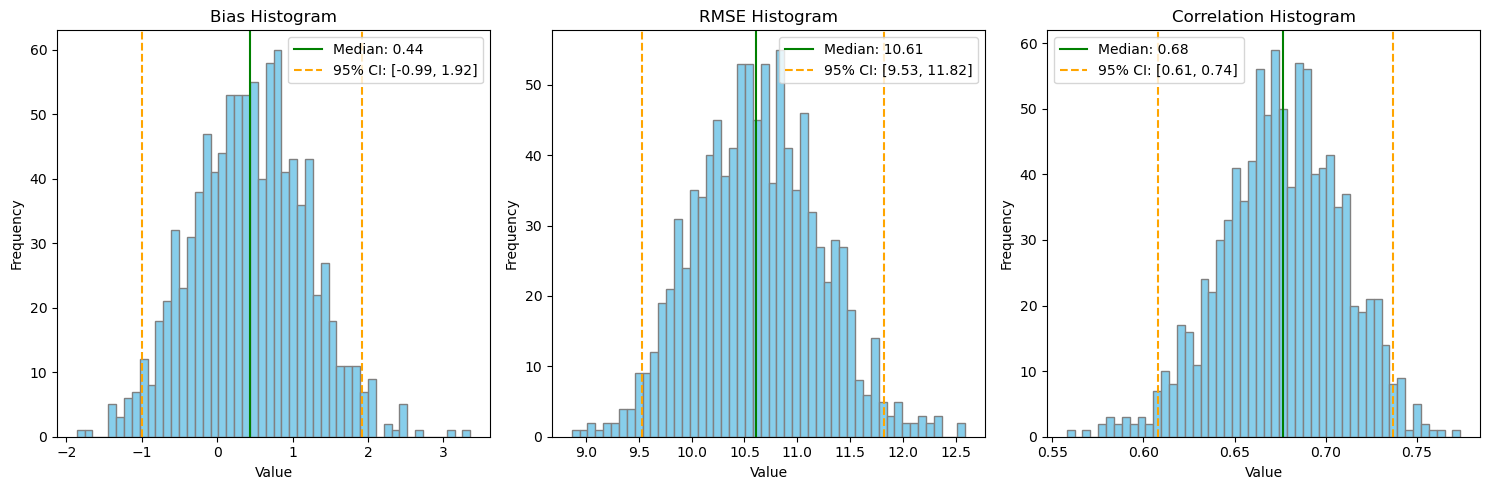

In [10]:
# Define metric names
metric_names = ['Bias', 'RMSE', 'Correlation']

# Create subplots
fig, axes = plt.subplots(1, len(metric_names), figsize=(len(metric_names) * 5, 5))

for ax, name in zip(axes, metric_names):
    data = metrics[name]
    median_val = np.median(data)
    confidence_interval = np.percentile(data, [2.5, 97.5])
    
    ax.hist(data, bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(confidence_interval[1], color='orange', linestyle='--')
    
    ax.set_title(f'{name} Histogram')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()